# Main Notebook to Perform Trading

### Imports

In [1]:
import matplotlib.pyplot as plt

from functions.data_collection import get_current_sp500_ticker_sample, get_historical_data
from functions.computing import compute_momentum, compute_mean_reversion, compute_signal_returns
from functions.signals import generate_signals_momentum, generate_signals_meanreversion, generate_final_signal
from functions.trading import build_strategy_choice_label, build_feature_matrix, track_strategy_chosen_signals
from functions.training import train_strategy_chooser
from functions.analysis import count_strategy_choices, build_trade_log, get_trades_for_stock
from functions.risk_management import apply_stop_loss

import warnings
warnings.filterwarnings("ignore")

### Get Data

In [2]:
# Get a random sample of S&P 500 tickers
tickers = get_current_sp500_ticker_sample(n=15, seed=None)
tickers.append("SPY")


# Download historical data
start_date = "2015-01-01"
end_date = "2025-01-01"
data = get_historical_data(tickers, start=start_date, end=end_date)
data = data.loc[start_date:end_date].dropna(axis=1, how='any')
spy_series = data["SPY"] # S&P 500

if "SPY" not in data.columns:
    raise ValueError("SPY data is missing after filtering.")

print("Historical Data Shape:", data.shape)
display(data.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Historical Data Shape: (2516, 14)


,GOOG,SO,TPL,IPG,AWK,FRT,CDNS,AVB,BXP,SLB,GILD,DHR,LII,SPY
Date,,,,,,,,,,,,,,
2024-12-24,197.570007,83.160004,1161.199951,28.340000,124.954208,111.622337,308.579987,221.553009,75.124100,37.469128,93.949997,230.480621,629.947876,601.299988
2024-12-26,197.100006,82.839996,1167.010010,28.549999,125.381554,111.681747,308.690002,221.582779,75.222786,37.469128,94.410004,231.009995,628.460693,601.340027
2024-12-27,194.039993,83.139999,1145.119995,28.110001,124.516922,110.335106,305.029999,219.469238,73.624184,37.538647,94.110001,231.100006,618.868713,595.010010
2024-12-30,192.690002,82.379997,1107.430054,27.790001,123.473396,109.830116,301.859985,218.089996,73.189995,37.548576,92.010002,229.649994,612.839966,588.219971
2024-12-31,190.440002,82.320000,1105.959961,28.020000,123.721855,110.849998,300.459991,219.970001,74.360001,38.074913,92.370003,229.550003,609.299988,586.080017


### Compute Signals

In [3]:
# Compute Momentum & Mean-Reversion
momentum_df = compute_momentum(data, window=63)  # 3-month
zscore_df   = compute_mean_reversion(data, window=20)

In [4]:
# Generate separate signals
momentum_signals = generate_signals_momentum(momentum_df, threshold=0.10) # 10%
meanrev_signals = generate_signals_meanreversion(zscore_df, z_entry=1.0)

In [5]:
# Compute next-day returns from each approach
momentum_returns = compute_signal_returns(data, momentum_signals)
meanrev_returns = compute_signal_returns(data, meanrev_signals)
label = build_strategy_choice_label(momentum_returns, meanrev_returns)

### Train Model

In [6]:
# Build features & train the "strategy chooser"
features = build_feature_matrix(data, momentum_df, zscore_df, vol_window=20)
clf = train_strategy_chooser(features, label)

Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best CV Score: 0.5224489795918368


### Results

In [7]:
# Generate the signals day by day based on classifier
signals = generate_final_signal(
    clf,
    features,
    momentum_signals,
    meanrev_signals
)

# Apply stop-loss to the signals
final_signals = apply_stop_loss(signals, data, 0.05)

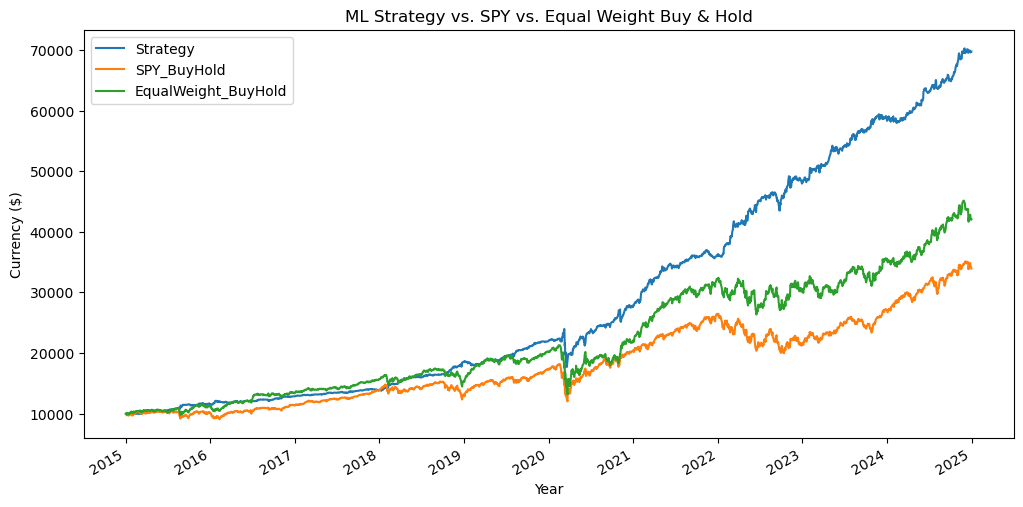

                Strategy   SPY_BuyHold  EqualWeight_BuyHold
Date                                                       
2024-12-24  69921.965927  34839.211613         42773.188637
2024-12-26  69708.152562  34841.531469         42824.645319
2024-12-27  69588.899947  34474.771434         42413.544763
2024-12-30  69732.059397  34081.357809         41973.034677
2024-12-31  69732.059397  33957.369287         42074.641355


In [8]:
# Track performance
result_df = track_strategy_chosen_signals(data, final_signals, spy_series)

# Plot all three equity curves
result_df[['Strategy', 'SPY_BuyHold', 'EqualWeight_BuyHold']].plot(
    figsize=(12, 6), title="ML Strategy vs. SPY vs. Equal Weight Buy & Hold"
)
plt.ylabel("Currency ($)")
plt.xlabel("Year")
plt.show()

print(result_df.tail())

### Testing and Analysis

In [9]:
n_mom, n_mr = count_strategy_choices(clf, features)

Momentum chosen:       912 days
Mean Reversion chosen: 283 days


In [10]:
trade_log = build_trade_log(final_signals, data)
print(trade_log.head(10))

        Date Ticker     Action       Price
0 2020-02-24   AAPL  OPEN_LONG   72.441597
1 2020-02-24    SPY  OPEN_LONG  298.923492
2 2020-02-24     BA  OPEN_LONG  317.899994
3 2020-02-24   SBUX  OPEN_LONG   76.311768
4 2020-02-24     GS  OPEN_LONG  198.675735
5 2020-02-24    JNJ  OPEN_LONG  127.821838
6 2020-02-24    DIS  OPEN_LONG  131.386887
7 2020-02-24    PEP  OPEN_LONG  123.541054
8 2020-02-24   INTC  OPEN_LONG   54.746277
9 2020-02-24   ORCL  OPEN_LONG   48.836918


Total trades for AAPL: 428

Showing the first 5 trades for AAPL:

          Date Ticker       Action      Price
0   2020-02-24   AAPL    OPEN_LONG  72.441597
24  2020-02-25   AAPL   CLOSE_LONG  69.987831
62  2020-04-02   AAPL   OPEN_SHORT  59.504719
84  2020-04-03   AAPL  CLOSE_SHORT  58.649555
110 2020-04-08   AAPL   OPEN_SHORT  64.640587


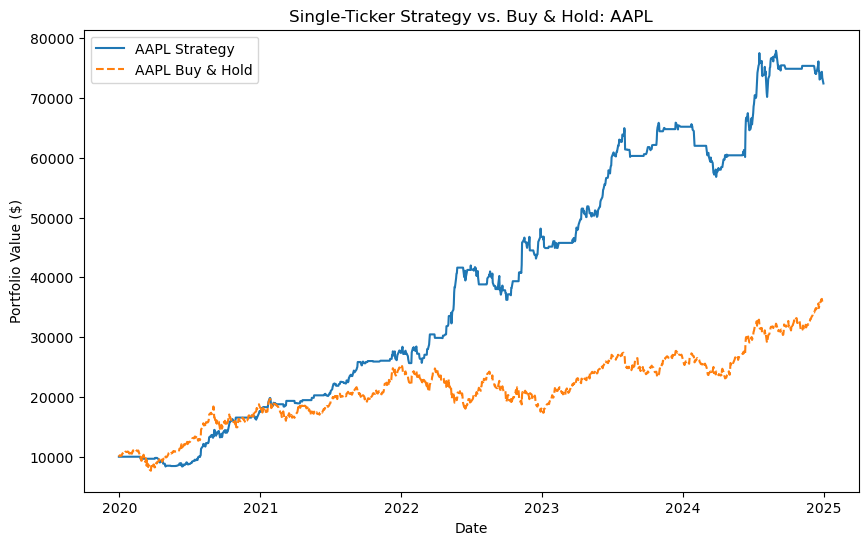

In [14]:
filtered_trades, equity, buyhold = get_trades_for_stock(
    trade_log_df=trade_log,
    final_signals=final_signals,
    price_data=data,
    ticker='AAPL', # Some good: MSFT, AAPL, Some bad: BA
    show_trade_count=5,
    initial_capital=10000.0
)